<a href="https://colab.research.google.com/github/liudiepie/Introduction_to_Machine_Learning/blob/main/W6_Assignment_Reinforcement_Learning_SARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep SARSA Cart Pole

Q-learning update rule:
\begin{equation}
Q_\pi (s_t, a_t) \leftarrow (1 - \alpha) \cdot Q_\pi(s_t, a_t) + \alpha \cdot \big(r_t + \gamma \max_a Q_\pi(s_{t+1}, a)\big)
\end{equation}

SARSA update rule:
\begin{equation}
Q_\pi (s_t, a_t) \leftarrow (1 - \alpha) \cdot Q_\pi(s_t, a_t) + \alpha \cdot \big(r_t + \gamma Q_\pi(s_{t+1}, a_{t+1})\big)
\end{equation}

In [1]:
!pip install gym

In [2]:
import gym

In [3]:
env = gym.make('FrozenLake-v0')
env.observation_space
env.action_space
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [4]:
# Non-slippery version

from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)
env = gym.make('FrozenLakeNotSlippery-v0')
env.reset()

0

In [5]:
env.step(0)
env.render()

  (Left)
SFFF
FHFH
FFFH
HFFG


In [6]:
env.reset()
done = False

while not done:
    env.render()
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


In [7]:
import numpy as np

#Initialize table with all zeros to be uniform
Q = np.zeros([env.observation_space.n, env.action_space.n])

In [8]:
# Learning parameters
alpha = 0.1
gamma = 0.95
num_episodes = 2000

# array of reward for each episode
rs = np.zeros([num_episodes])

In [9]:
for i in range(num_episodes):
    # Set total reward and time to zero, done to False
    r_sum_i = 0
    t = 0
    done = False
    
    #Reset environment and get first new observation
    s = env.reset()
    
    while not done:
        # Choose an action by greedily (with noise) from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i/10+1)))
        
        # Get new state and reward from environment
        s1, r, done, _ = env.step(a)
        
        # Update Q-Table with new knowledge
        Q[s,a] = (1 - alpha)*Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]))
        
        # Add reward to episode total
        r_sum_i += r*gamma**t
        
        # Update state and time
        s = s1
        t += 1
    rs[i] = r_sum_i

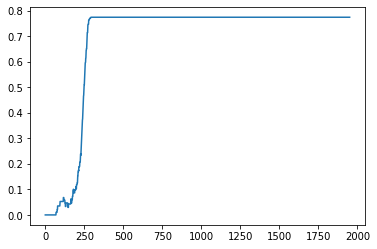

In [10]:
## Plot reward vs episodes
import matplotlib.pyplot as plt

# Sliding window average
r_cumsum = np.cumsum(np.insert(rs, 0, 0)) 
r_cumsum = (r_cumsum[50:] - r_cumsum[:-50]) / 50

# Plot
plt.plot(r_cumsum)
plt.show()

In [11]:
# Print number of times the goal was reached
N = len(rs)//10
num_Gs = np.zeros(10)

for i in range(10):
    num_Gs[i] = np.sum(rs[i*N:(i+1)*N] > 0)
    
print("Rewards: {0}".format(num_Gs))

Rewards: [  8. 146. 200. 200. 200. 200. 200. 200. 200. 200.]


In [12]:

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2444 sha256=e58328705a27fde541e7b59674ff3cb80c0446414ff7524294a877d451c98bdf
  Stored in directory: /root/.cache/pip/wheels/1f/56/73/3697080da5fc7b120516aef37d1d1eb2380515ba9e272b8ccd
Successfully built colabgymrender


In [13]:
import gym
from colabgymrender.recorder import Recorder

env = gym.make("CartPole-v0")
env = Recorder(env, '/.video')

observation = env.reset()
terminal = False
while not terminal:
  action = env.action_space.sample()
  observation, reward, terminal, info = env.step(action)

env.play()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2228224/45929032 bytes (4.9%)5636096/45929032 bytes (12.3%)8585216/45929032 bytes (18.7%)12001280/45929032 bytes (26.1%)15630336/45929032 bytes (34.0%)19152896/45929032 bytes (41.7%)22700032/45929032 bytes (49.4%)26247168/45929032 bytes (57.1%)29728768/45929032 bytes (64.7%)33193984/45929032 bytes (72.3%)36724736/45929032 bytes (80.0%)39944192/45929032 bytes (87.0%)

 95%|█████████▍| 18/19 [00:00<00:00, 222.00it/s]


In [17]:
import gym
from colabgymrender.recorder import Recorder

env = gym.make("CartPole-v0")
env.observation_space
env.action_space
env.reset()
done = False

while not done:
    env.render()
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)

In [18]:
env.close()

In [16]:
from collections import deque
import random
import math

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 48)
        self.fc3 = nn.Linear(48, 2)

    def forward(self, x):        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x        
    

class DQNCartPoleSolver:
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.dqn = DQN()
        self.criterion = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.dqn.parameters(), lr=0.01)

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def exploit_action(self, state):
      with torch.no_grad():
        return torch.argmax(self.dqn(state)).numpy()

    def preprocess_state(self, state):
        return torch.tensor(np.reshape(state, [1, 4]), dtype=torch.float32) 
    
    def choose_action(self, state, epsilon):
        if (np.random.random() <= epsilon):
            return self.env.action_space.sample() 
        else:
            with torch.no_grad():
                return torch.argmax(self.dqn(state)).numpy()

    def remember(self, state, action, reward, next_state, done):
        reward = torch.tensor(reward)
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        y_batch, y_target_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y = self.dqn(state)
            y2 = self.dqn(next_state)
            action2 = self.exploit_action(next_state)
            y_target = y.clone().detach()
            with torch.no_grad():
                y_target[0][action] = reward if done else reward + self.gamma * y2[0][action2]
            y_batch.append(y[0])
            y_target_batch.append(y_target[0])
        
        y_batch = torch.cat(y_batch)
        y_target_batch = torch.cat(y_target_batch)
        
        self.opt.zero_grad()
        loss = self.criterion(y_batch, y_target_batch)
        loss.backward()
        self.opt.step()        
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            while not done:
                if e % 100 == 0 and not self.quiet:
                    self.env.render()
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e

if __name__ == '__main__':
    agent = DQNCartPoleSolver()
    agent.run()
    agent.env.close()

[Episode 0] - Mean survival time over last 100 episodes was 12.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 19.99 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 36.14 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 38.9 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 133.84 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 144.15 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 154.36 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 113.38 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 150.17 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 180.27 ticks.
Did not solve after 999 episodes 😞
